In [1]:
import os
os.chdir(os.path.dirname(os.getcwd()))

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
keras = tf.keras
from datetime import datetime

from typing import List

import os
import glob

from src.io.load import DataLoader

from dataclasses import dataclass, field
from typing import Dict
from src.action_strategy.factory import ActionStrategy
from src.action_strategy.mean_reversion import MeanReversion
from src.forecast.factory import ModelForecastFactory
from src.forecast.runner import ForecastRunner
from src.forecast.utils import SamplerSetForecast
from src.io.load import DataLoader, load_config
from src.io.save import Dumper
from src.preprocessing.preprocess import ProcessData
from src.stock import Balance, Stock
import logging
from src.trade_manager import TradeManagerV0
from datetime import datetime, timedelta
import math
from abc import ABC, abstractmethod

In [3]:
PATH_DATA_RESULTS = "results/"

In [4]:
import logging
from src.main import load_config, load_data, Experiment

In [5]:
logging.basicConfig()
log=logging.getLogger(__name__)
log.setLevel(logging.DEBUG)

In [6]:
import plotly.express as px
import plotly.graph_objects as go

In [28]:
PATH_DATA_RESULTS

'results/'

In [29]:
ls results/test_germany_20221108_204121/

results_test_germany_test_germany_20221108_204121.xlsx


### Load data

In [44]:
batch_name = "full_year_germany_20221108_204632"
trading_data = pd.read_excel(os.path.join(PATH_DATA_RESULTS, batch_name, f"results_{batch_name}.xlsx"), index_col=0)

In [45]:
trading_data.loc[trading_data.action == "SELL", "true_prices"].mean()

39.859009159034166

In [46]:
trading_data

,true_prices,price_flow,action,current_balance,energy_trade,current_cpty,mean,std,upper_bollinger,lower_bollinger,pred_prices
2020-01-01 13:00:00,30.75,-3075.000,BUY,-2075.000000,-100.00,86.0,35.846957,6.166914,40.163796,31.530117,30.784292
2020-01-01 14:00:00,32.11,0.000,HOLD,-2075.000000,0.00,86.0,34.739130,5.651647,38.695283,30.782978,32.850411
2020-01-01 15:00:00,35.98,0.000,HOLD,-2075.000000,0.00,86.0,34.228261,4.905835,37.662345,30.794177,35.649802
2020-01-01 16:00:00,40.40,2987.984,SELL,912.984000,73.96,0.0,33.984783,4.408833,37.070966,30.898600,37.334166
2020-01-01 17:00:00,44.05,0.000,HOLD_s,912.984000,0.00,0.0,34.065217,4.579112,37.270595,30.859839,37.603027
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 08:00:00,48.19,0.000,HOLD,468439.677041,0.00,930.0,45.404348,9.866615,52.310978,38.497717,38.718738
2020-12-31 09:00:00,43.23,0.000,HOLD,468439.677041,0.00,930.0,45.025217,9.770731,51.864729,38.185705,39.595432
2020-12-31 10:00:00,43.57,0.000,HOLD,468439.677041,0.00,930.0,44.500870,9.495479,51.147705,37.854034,40.263511
2020-12-31 11:00:00,50.52,0.000,HOLD,468439.677041,0.00,930.0,44.346522,9.360761,50.899054,37.793989,40.005251


In [47]:
trading_data.action.value_counts()

HOLD      4019
BUY       1617
SELL      1201
HOLD_b    1044
HOLD_s     879
Name: action, dtype: int64

In [64]:
from sklearn.metrics import mean_absolute_error
import seaborn as sns

In [50]:
mean_absolute_error(trading_data["true_prices"], trading_data["pred_prices"])

7.989073505355767

In [67]:
diff = np.abs(trading_data["true_prices"] - trading_data["pred_prices"])

<AxesSubplot:>

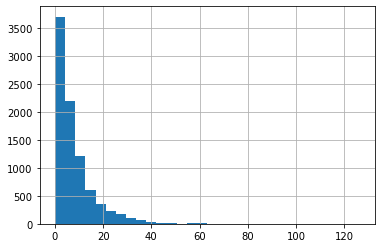

In [56]:
diff.hist(bins=30)

In [57]:
diff.describe()

count    8760.000000
mean        7.989074
std         8.865142
min         0.000827
25%         2.217473
50%         5.325161
75%        10.406598
max       126.199315
dtype: float64

In [60]:
trading_data.index = pd.to_datetime(trading_data.index)

In [62]:
diff

2020-01-01 13:00:00     0.034292
2020-01-01 14:00:00     0.740411
2020-01-01 15:00:00     0.330198
2020-01-01 16:00:00     3.065834
2020-01-01 17:00:00     6.446973
                         ...    
2020-12-31 08:00:00     9.471262
2020-12-31 09:00:00     3.634568
2020-12-31 10:00:00     3.306489
2020-12-31 11:00:00    10.514749
2020-12-31 12:00:00    12.825953
Length: 8760, dtype: float64

In [71]:
diff

2020-01-01 13:00:00     0.034292
2020-01-01 14:00:00     0.740411
2020-01-01 15:00:00     0.330198
2020-01-01 16:00:00     3.065834
2020-01-01 17:00:00     6.446973
                         ...    
2020-12-31 08:00:00     9.471262
2020-12-31 09:00:00     3.634568
2020-12-31 10:00:00     3.306489
2020-12-31 11:00:00    10.514749
2020-12-31 12:00:00    12.825953
Length: 8760, dtype: float64

(0.0, 40.0)

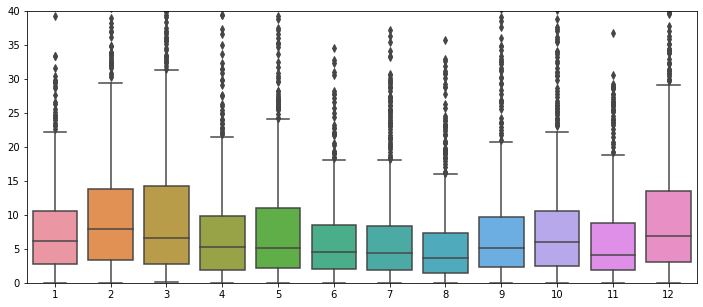

In [76]:
fig, ax = plt.subplots(figsize=(12,5))
sns.boxplot(x=diff.index.month, y=diff, ax=ax)
ax.set_ylim([0, 40])

In [61]:
trading_data.loc["2020-11-26"]

,true_prices,price_flow,action,current_balance,energy_trade,current_cpty,mean,std,upper_bollinger,lower_bollinger,pred_prices
2020-11-26 00:00:00,37.25,-3725.000000,BUY,415650.288865,-100.000000,692.604651,47.655652,8.389798,53.528511,41.782794,33.121907
2020-11-26 01:00:00,36.68,-3668.000000,BUY,411982.288865,-100.000000,778.604651,47.804348,8.149939,53.509305,42.099390,32.460049
2020-11-26 02:00:00,36.51,-3651.000000,BUY,408331.288865,-100.000000,864.604651,47.908261,7.981016,53.494972,42.321549,31.098899
2020-11-26 03:00:00,36.67,-2788.427258,BUY,405542.861607,-76.041103,930.000000,47.960435,7.899515,53.490095,42.430775,31.666497
2020-11-26 04:00:00,37.93,0.000000,HOLD_b,405542.861607,0.000000,930.000000,47.740435,8.111839,53.418722,42.062147,33.778389
2020-11-26 05:00:00,45.84,0.000000,HOLD_b,405542.861607,0.000000,930.000000,47.426957,8.036288,53.052358,41.801555,38.668244
2020-11-26 06:00:00,59.93,0.000000,HOLD,405542.861607,0.000000,930.000000,47.706522,8.362386,53.560192,41.852851,43.900305
2020-11-26 07:00:00,65.69,0.000000,HOLD,405542.861607,0.000000,930.000000,48.256957,9.111797,54.635215,41.878698,45.742753
2020-11-26 08:00:00,64.26,0.000000,HOLD,405542.861607,0.000000,930.000000,48.818696,9.690392,55.601970,42.035421,43.606675
2020-11-26 09:00:00,58.51,0.000000,HOLD_b,405542.861607,0.000000,930.000000,49.145652,9.891754,56.069880,42.221425,41.988071


In [58]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=trading_data.index, y=trading_data["true_prices"],
                    mode='lines',
                    name='true'))

fig.add_trace(go.Scatter(x=trading_data.index, y=trading_data["pred_prices"],
                    mode='lines',
                    name='pred'))

buy_action = trading_data[trading_data.action == "BUY"]
fig.add_trace(go.Scatter(mode="markers", 
                         x=buy_action.index, y=buy_action["true_prices"], 
                         marker=dict(
                             symbol="triangle-down",
                             size=6,
                             color="red"
                         ),
                        name="buy"

                        )
             )

sell_action = trading_data[trading_data.action == "SELL"]
fig.add_trace(go.Scatter(mode="markers", 
                         x=sell_action.index, y=sell_action["true_prices"], 
                         marker=dict(
                             symbol="triangle-up",
                             size=6,
                             color="green"
                         ),
                         name="sell"
                        )
             )

w_hold_action = trading_data[trading_data.action.isin(["HOLD_s", "HOLD_b"])]
fig.add_trace(go.Scatter(mode="markers", 
                         x=w_hold_action.index, y=w_hold_action["true_prices"], 
                         marker=dict(
                             symbol="square",
                             size=4,
                             color="orange"
                         ),
                         name="false hold"
                        )
             )

fig.update_xaxes(rangeslider_visible=True, minor=dict(ticks="inside", showgrid=True))

fig.update_layout(
    autosize=True,
    width=1000,
    height=600,
    yaxis=dict(
        title_text="prices",
    )
)

### Notes
* 26-11-2020 : upper bollinger sur évaluée
* alpha a faire varier par mois
* memoire à entrainer
* matrices tests
* reporting results:
   * diff per quartile
   * mae
   * mape
   * boxplots mois

In [33]:
trading_data

,true_prices,price_flow,action,current_balance,energy_trade,current_cpty,mean,std,upper_bollinger,lower_bollinger,pred_prices
2020-01-01 13:00:00,30.75,-3075.000,BUY,-2075.000000,-100.00,86.000000,35.846957,6.166914,40.163796,31.530117,30.784292
2020-01-01 14:00:00,32.11,0.000,HOLD,-2075.000000,0.00,86.000000,34.739130,5.651647,38.695283,30.782978,32.850411
2020-01-01 15:00:00,35.98,0.000,HOLD,-2075.000000,0.00,86.000000,34.228261,4.905835,37.662345,30.794177,35.649802
2020-01-01 16:00:00,40.40,2987.984,SELL,912.984000,73.96,0.000000,33.984783,4.408833,37.070966,30.898600,37.334166
2020-01-01 17:00:00,44.05,0.000,HOLD_s,912.984000,0.00,0.000000,34.065217,4.579112,37.270595,30.859839,37.603027
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-30 08:00:00,2.58,258.000,SELL,231082.241458,100.00,217.813953,23.840000,7.896662,29.367663,18.312337,33.609998
2020-06-30 09:00:00,0.39,39.000,SELL,231121.241458,100.00,101.534884,22.580870,9.182339,29.008507,16.153232,30.923648
2020-06-30 10:00:00,0.92,0.000,HOLD,231121.241458,0.00,101.534884,21.636957,10.232827,28.799935,14.473978,28.760401
2020-06-30 11:00:00,-0.08,0.000,HOLD,231121.241458,0.00,101.534884,20.677826,11.188440,28.509734,12.845918,27.153938


In [21]:
28*930 + 44000

70040

In [12]:
trading_data[trading_data.action == "SELL"]["true_prices"].mean()

28.401666666666667

In [56]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=trading_data.index, y=trading_data["current_balance"],
                    mode='lines',
                    name='balance'))

In [55]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=trading_data.index, y=trading_data["current_cpty"],
                    mode='lines',
                    name='cpty'))

In [59]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=trading_data.index, y=trading_data["price_flow"],
                    mode='lines',
                    name='flow_money'))